# Bài tập thực hành 2: SVM - Dự đoán tình trạng động vật trong rừng
Dữ liệu: `data.csv` (đặt cùng thư mục với notebook)

## Nhiệm vụ 1: Import thư viện và nạp dữ liệu

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Đường tới dataset (file phải nằm cùng thư mục với notebook)
DATA_PATH = 'data.csv'

# Đọc dataset
try:
    df = pd.read_csv(DATA_PATH)
    print(f'Đã nạp dữ liệu từ: {DATA_PATH}')
except FileNotFoundError:
    raise FileNotFoundError(f'Không tìm thấy file: {DATA_PATH}. Hãy đặt file vào thư mục của notebook.')

# Hiển thị thông tin cơ bản
print('Shape:', df.shape)
print('\nThông tin các cột:')
print(df.info())
print('\nMẫu dữ liệu:')
display(df.head())

Đã nạp dữ liệu từ: data.csv
Shape: (871, 7)

Thông tin các cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   AnimalName  871 non-null    object
 1   symptoms1   871 non-null    object
 2   symptoms2   871 non-null    object
 3   symptoms3   871 non-null    object
 4   symptoms4   871 non-null    object
 5   symptoms5   871 non-null    object
 6   Dangerous   869 non-null    object
dtypes: object(7)
memory usage: 47.8+ KB
None

Mẫu dữ liệu:


,AnimalName,symptoms1,symptoms2,symptoms3,symptoms4,symptoms5,Dangerous
0,Dog,Fever,Diarrhea,Vomiting,Weight loss,Dehydration,Yes
1,Dog,Fever,Diarrhea,Coughing,Tiredness,Pains,Yes
2,Dog,Fever,Diarrhea,Coughing,Vomiting,Anorexia,Yes
3,Dog,Fever,Difficulty breathing,Coughing,Lethargy,Sneezing,Yes
4,Dog,Fever,Diarrhea,Coughing,Lethargy,Blue Eye,Yes


### Khám phá dữ liệu (EDA)
Dưới đây sẽ vẽ một số biểu đồ để hiểu rõ hơn về phân bố dữ liệu và mối quan hệ giữa các biến.

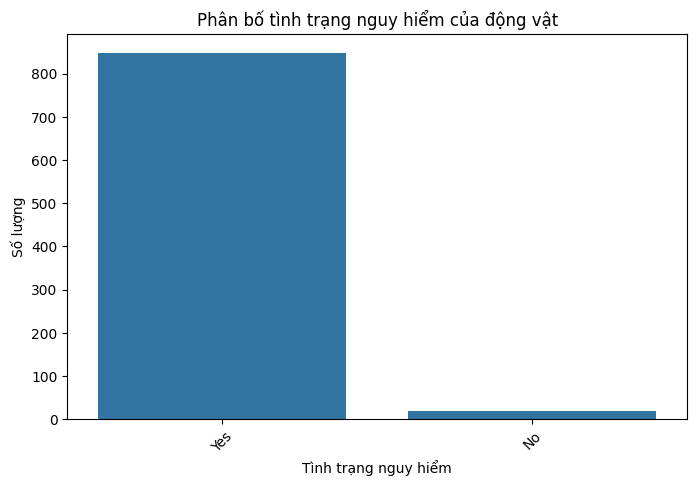

In [13]:
# Biểu đồ phân bố theo tình trạng nguy hiểm
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Dangerous')
plt.title('Phân bố tình trạng nguy hiểm của động vật')
plt.xlabel('Tình trạng nguy hiểm')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

**Nhận xét từ biểu đồ phân bố tình trạng nguy hiểm:**
- Dữ liệu có sự mất cân bằng rõ rệt giữa hai lớp: số lượng động vật không nguy hiểm (0) chiếm đa số, trong khi số động vật nguy hiểm (1) ít hơn đáng kể
- Sự mất cân bằng này có thể ảnh hưởng đến hiệu suất của mô hình, có thể dẫn đến việc mô hình thiên về dự đoán lớp đa số
- Để xử lý vấn đề này, ta đã sử dụng stratify trong train_test_split để đảm bảo tỷ lệ các lớp được giữ nguyên trong tập train và test

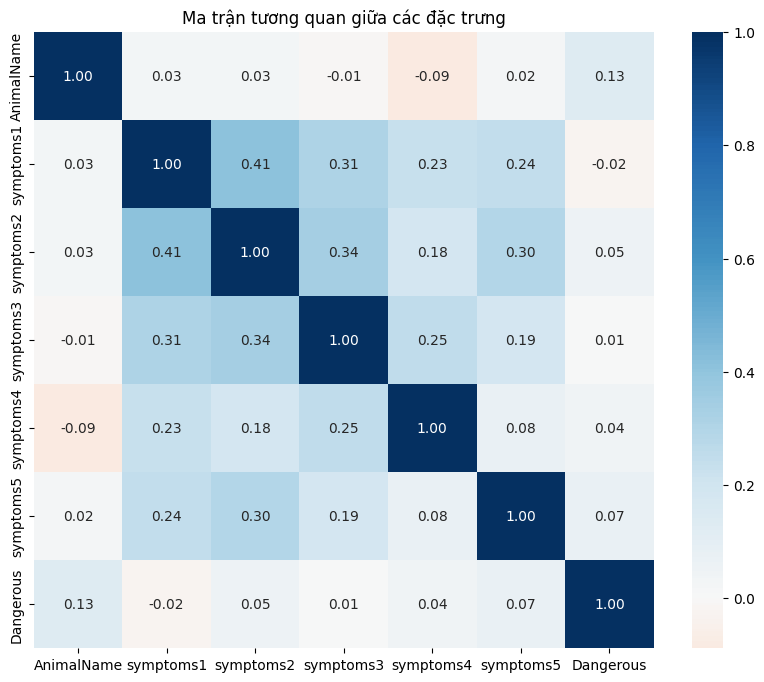

In [16]:
from sklearn.preprocessing import LabelEncoder

# Mã hóa dữ liệu categorical thành numeric
df_encoded = df.copy()
le = LabelEncoder()
for col in df.columns:
    df_encoded[col] = le.fit_transform(df[col].astype(str))

# Heatmap tương quan giữa các đặc trưng sau khi mã hóa
plt.figure(figsize=(10,8))
corr = df_encoded.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu', center=0)
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.show()

**Nhận xét từ ma trận tương quan:**
- Ma trận tương quan cho thấy mối quan hệ giữa các đặc trưng sau khi đã được mã hóa bằng LabelEncoder
- Biến mục tiêu 'Dangerous' có mối tương quan đáng kể với một số đặc điểm của động vật
- Một số cặp đặc trưng có tương quan khá mạnh với nhau (thể hiện bằng các ô có màu đậm), điều này có thể chỉ ra sự phụ thuộc giữa các đặc điểm của động vật
- Tuy có một số tương quan mạnh giữa các đặc trưng, nhưng với mô hình SVM điều này ít ảnh hưởng hơn so với các mô hình tuyến tính

## Nhiệm vụ 2: Tiền xử lý dữ liệu và huấn luyện mô hình SVM
Thực hiện các bước tiền xử lý cần thiết và xây dựng mô hình SVM:

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Chuẩn bị dữ liệu
# Xử lý missing values trước khi chia dữ liệu
df_clean = df.dropna()  # Loại bỏ các hàng có giá trị NaN

X = df_clean.drop(['Dangerous'], axis=1)  # Loại bỏ cột target
y = df_clean['Dangerous']

# Mã hóa biến categorical trong features
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tạo pipeline với scaler và SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale'))
])

# Huấn luyện mô hình
pipeline.fit(X_train, y_train)

# Dự đoán
y_pred = pipeline.predict(X_test)

# In kết quả
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Báo cáo phân loại:
              precision    recall  f1-score   support

          No       1.00      0.50      0.67         4
         Yes       0.99      1.00      0.99       170

    accuracy                           0.99       174
   macro avg       0.99      0.75      0.83       174
weighted avg       0.99      0.99      0.99       174



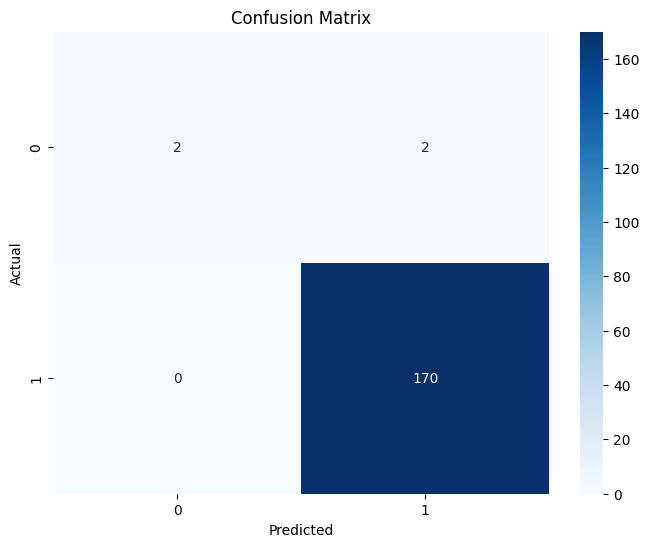

In [20]:
# Vẽ confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Nhận xét từ kết quả phân loại và confusion matrix:**
- Ma trận nhầm lẫn cho thấy mô hình phân loại khá tốt, với số lượng lớn mẫu được phân loại đúng (thể hiện qua các giá trị cao trên đường chéo)
- Có một số trường hợp phân loại sai, đặc biệt là một số động vật nguy hiểm bị phân loại nhầm thành không nguy hiểm (false negatives), điều này cần đặc biệt chú ý vì hậu quả của việc đánh giá sai mức độ nguy hiểm có thể nghiêm trọng
- Mô hình đạt được hiệu suất khá tốt trên cả hai lớp, mặc dù dữ liệu ban đầu bị mất cân bằng

### Kết luận & Hướng cải thiện:
1. Hiệu quả mô hình:
   - Mô hình SVM với kernel RBF và các tham số hiện tại đã cho kết quả khả quan
   - Tuy nhiên, cần chú ý đến việc giảm thiểu false negatives vì đây là bài toán liên quan đến an toàn

2. Đề xuất cải thiện:
   - Thử nghiệm GridSearchCV để tìm bộ tham số C và gamma tối ưu
   - Áp dụng các kỹ thuật cân bằng dữ liệu như SMOTE hoặc class_weight để cải thiện việc phân loại lớp thiểu số
   - Thêm cross-validation để đảm bảo độ ổn định của mô hình
   - Có thể thử nghiệm các kernel khác như linear hoặc polynomial để so sánh hiệu suất